Projection to Latent Structures (PLS)
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: Discussion and examples of [PLS](https://en.wikipedia.org/wiki/Partial_least_squares_regression). For more information, see [All Models Are Wrong](https://allmodelsarewrong.github.io/pls.html).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/learn/pls.ipynb)

[Partial least squares (PLS) regression](https://en.wikipedia.org/wiki/Partial_least_squares_regression) is also known as "projection to latent structures". There are several variations on the algorithm which are available in [sklearn](https://scikit-learn.org/stable/modules/cross_decomposition.html), however the commonly used "PLS1" (if y has one column) or "PLS2" (if y has multiple columns) are variations on [PLSCanonical](https://scikit-learn.org/stable/modules/cross_decomposition.html#plscanonical).  In sklearn, these are implemented with the [PLSRegression](https://scikit-learn.org/stable/modules/cross_decomposition.html#plsregression) function which we will focus on here.  PLS is really a large family of methods - a nice introduction can be found [here](https://allmodelsarewrong.github.io/pls.html).

In essence PLS is actually a scheme to project both X and Y while taking each other into account (so this is considered supervised).  This is motivated by the previous example of [PCR](pca_pcr.ipynb) showing that just because the data ($X$) is naturally spread out in certain dimensions does not necessarily mean the that response variable ($Y$) is correlated with that distribution.  Assume we model **centered matrices** $X$ and $Y$ as follows:

$$X = TP^T + E,$$

$$Y = UQ^T + F,$$

where $E$ and $F$ are error terms (assumed to be IID). $X$ has dimensions $n \times p$, and $Y$ has dimensions $n \times l$; $T$ and $U$ are the $n \times k$ projection matrices of $X$ and $Y$, respectively.  Here, $k \le p$ represents a dimensionality reduction; while $P$ is $p \times k$ and $Q$ is $l \times k$. $T$ and $U$ are the x- and y-scores matrices, while $P$ and $T$ are the x- and y-loadings matrices, respectively.  <!--PLS has different variations, some of which do certain scaling, etc. so the terminology is not exactly the same as PCA, where the loadings were the eigenvectors scaled by the (square root of their) eigenvalues.-->

This is particularly useful when (1) we have more regressors than observations ($p > n$), or (2) when the output is correlated with **dimensions that have low variance**, in which case unsupervised PCA will discard those dimensions, and with them, predictive power.

The PLS algorithm rotates and projects $X$ into a lower $k$-dimensional space, represented by the x-scores matrix $T$, and similarly projects $Y$ into the same dimensional space, $U$ (y-scores), where the projections are determined in a non-linear fashion by sharing information about the decompositions above with each other. Essentially, the decomposition is designed to maximize the covariance between the x and y scores ($T$ and $U$ matrices).

Originally, this was inspired by the [non-linear iterative partial least squares](https://cran.r-project.org/web/packages/nipals/vignettes/nipals_algorithm.html) algorithm as described [here](https://doi.org/10.1016/0003-2670(86)80028-9); this is just an interative algorithm to find principal components.  Essentially, one could do NIPALS to get an eigendecomposition of $X$ and $Y$ independently, then do regression between them, similar to PCR; however, in this approach $X$ and $Y$ have independent decompositions which might not be good representations of each other, as we saw in the [PCR](pca_pcr.ipynb) example.  One way to circumvent this is to **"trade" information during the iteration** letting these decompositions influence each other.  

Consider using NIPALS to find the first eigenvalue without exchanging information.  

~~~python
t = X[:,0].reshape(-1,1) # Can select any non-zero column, let's just take the first
change = np.inf
while change > 1.0e-12:
    p = np.matmul(X.T, t) / np.matmul(t.T, t)
    p /= np.linalg.norm(p)
    new_t = np.matmul(X, p) # x-score
    change = np.linalg.norm(new_t - t) # Keep track of how it changes
    t = new_t
lambda_x_0 = np.sqrt(np.matmul(t.T, t))
    
u = Y[:,0].reshape(-1,1) # Can select any non-zero column, let's just take the first
change = np.inf
while change > 1.0e-12:
    q = np.matmul(Y.T, u) / np.matmul(u.T, u)
    q /= np.linalg.norm(q)
    new_u = np.matmul(Y, q) # y-score
    change = np.linalg.norm(new_u - u) # Keep track of how it changes
    u = new_u
lambda_y_0 = np.sqrt(np.matmul(u.T, u))
~~~

Instead, to "exchange" information we can swap the scores in the update steps.

~~~python
t = X[:,0].reshape(-1,1) # Can select any non-zero column, let's just take the first
u = Y[:,0].reshape(-1,1) # Can select any non-zero column, let's just take the first
change = np.inf
while change > 1.0e-12:
    p = np.matmul(X.T, u) / np.matmul(u.T, u) # Use y-score here instead
    p /= np.linalg.norm(p)
    new_t = np.matmul(X, p) # x-score
    
    q = np.matmul(Y.T, new_t) / np.matmul(new_t.T, new_t) # Use x-score here instead
    q /= np.linalg.norm(q)
    new_u = np.matmul(Y, q) # y-score
    
    change = np.linalg.norm(new_t - t) # Keep track of how it changes
    t = new_t
    u = new_u  
~~~

These loops are repeated $k$ times, deflating the $X$ and $Y$ matrices each time, to obtain the top $k$ eigenvalues, etc.  When the loop above converges we have:

$$p = X^Tu / ||u||^2$$

$$\sim X^T(Yq)$$

$$\sim X^TY(Y^Tt)$$

$$\sim X^TYY^T(Xp)$$

$$\sim (Y^TX)^T(Y^TX)p$$

So we see that $p$ is an [eigenvector](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of the covariance matrix ${\rm cov}((Y^TX)^T) = {\rm cov}(X^TY)$. Thus, this can be interpreted as finding the decomposition that maximizes the variance of the product during each step (described below). See Hastie et al. "The Elements of Statistical Learning." or [here](https://www.jstor.org/stable/pdf/1269656.pdf?casa_token=cr6WyBAN7acAAAAA:OknO2R0VHg41_q0UOTo4Ribt2Z7dH8b5meHacIqSdT69GXeQJ_zd8N26I2EVexM0-bOMNqpaD4YYWuwMgw-1BenvoDcDSG10sfoimwCYOETgz9a8Lw) for more details.

Algorithmically, the formulation of PLS1 goes like this (PLS2 deals with multiple responses instead of a single colum for $\vec{y}$):

1. Mean-center X and Y.  Scaling is optional.

Then for $k$ steps:

2. Compute the first left and right singular vectors of the covariance of matrix, $C = X^TY$, $\vec{x_w}$ and $\vec{y_w}$ (column vectors). These vectors are called `weights` - note these are single vectors corresponding to this particular iteration, $k$.  The loadings matrices, $P$ and $Q$, will be computed later.

<!-- > Singular value decomposition (SVD) of a matrix, $X$, is given by $X=USV^T$.  NIPALS finds the decomposition, $X=TP^T$, where $T=U^TS$ and $P=V$, so for consistency $C$ appears to be a transpose of the cross-covariance matrix derived above. -->

> For canonical PLS the $\vec{y_w}$ vector is normalized, but for the "regression" version used by PLS1 and PLS2, it is not.

3. Use these weights to project $X$ and $Y$ obtaining the x- and y-scores in 1D: $\vec{t} = X \vec{x_w}$ and $\vec{u} = Y \vec{y_w}$.

4. Obtain the loadings by regressing the $X$ and $Y$ matrices using their scores. The $k^{\rm th}$ column in $P$ is given by $\vec{p} = X^T \vec{t} / (\vec{t}^T \vec{t})$.  In canonical PLS, a similar expression is used for the $Q$ matrix (y-loadings); however, in the "regression" version, $Y$ is instead regressed on x-scores not the y-scores: $\vec{q} = Y^T \vec{t} / (\vec{t}^T \vec{t})$.  So we have instead:

$$X = T P^T + E,$$

$$Y = T Q^T + F.$$

5. Deflate the matrices. We always have $X \rightarrow X - \vec{t}\vec{p}^T$. In canonical PLS, $Y \rightarrow Y - \vec{u}\vec{q}^T$; however for the "regression" version we again use the x-score information not the y-scores: $Y \rightarrow Y - \vec{t}\vec{q}^T$.
> Note that some algorithms do not require the deflation of $Y$ because it happens automatically (see [wiki](https://en.wikipedia.org/wiki/Partial_least_squares_regression)).

End loop

6. We have now approximated $X = TP^T$ as a sum of rank-1 matrices.  The columns of $T$ are the scores and $P^T$ has the loadings in its rows.  $Y$ is similarly related to its scores and loadings. Note that the dimensionality of the x- and y-projections (scores, $T$ and $U$) is the same. For convenience, we can define $XA = T$, which [provides the necessary](https://scikit-learn.org/stable/modules/cross_decomposition.html#transforming-data) transformation; sklearn refers to this as the `rotations` matrix (a similar one exists for Y). This formula is also proven [here](https://allmodelsarewrong.github.io/pls.html) in Eq. 16.20, and given on [Wikipedia](https://en.wikipedia.org/wiki/Partial_least_squares_regression):

$$A = X_w(P^TX_w)^{-1}.$$

7. For PLS regression we basically substituted $U \rightarrow T$ since we regressed $Y$ on the x-scores instead of the y-scores. Now we can obtain a final relationship for $Y$ in terms of $X$.  Recall that since $Y$ is centered there is no intercept to worry about.

$$Y = UQ^T \rightarrow T Q^T = X A Q^T.$$

$$Y = X (A Q^T) = XB.$$



In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [ ]:
if 'google.colab' in str(get_ipython()):
    !wget https://github.com/mahynski/pychemauth/raw/main/docs/jupyter/learn/utils.py

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [ ]:
import utils
import imblearn

import numpy as np

from pychemauth.preprocessing.scaling import CorrectedScaler

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

watermark : 2.4.3
json      : 2.0.9
pychemauth: 0.0.0b3
matplotlib: 3.7.2
imblearn  : 0.11.0
numpy     : 1.24.3



<h3>Create Some Data</h3>

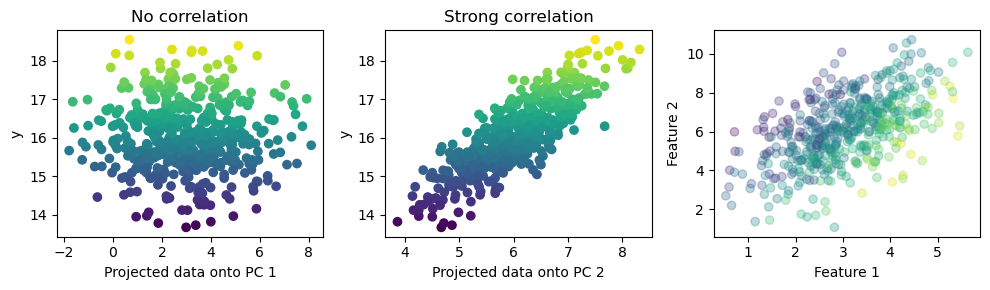

In [ ]:
X = utils.generate_data(mean=[3,6], cov=[[1, 1], [1, 3]], n_samples=500)
y, pca_gen = utils.generate_response(X, dimension=1, mean=[3,6], y_center=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Manual Iteration
---
Let's do an example of a single iteration of the above loop.

In [ ]:
X_manual = np.array([[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]])
y_manual = np.array([[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]])

In [ ]:
def manual_pls1(n_components, X, Y, style="canonical"):
    # Center the data - we will not scale it in this example
    X = CorrectedScaler(with_std=False).fit_transform(X)
    Y = CorrectedScaler(with_std=False).fit_transform(Y)

    # Trade information to compute the weights (vecvtors we use to do the projection)
    def nipals(X, Y):
        t = X[:,0].reshape(-1,1) # Can select any column, let's just take the first
        u = Y[:,0].reshape(-1,1) # Can select any column, let's just take the first
        change = np.inf
        while change > 1.0e-12:
            p = np.matmul(X.T, u) / np.matmul(u.T, u)
            p /= np.linalg.norm(p) # x-weight = normalized vector
            new_t = np.matmul(X, p) # x-score = projection of X

            q = np.matmul(Y.T, new_t) / np.matmul(new_t.T, new_t)
            if style == "canonical":
                q /= np.linalg.norm(q) # y-weight = normalized vector in Canonical PLS, but not PLSRegression
            new_u = np.matmul(Y, q) # y-score = projection of Y

            change = np.linalg.norm(new_t - t) # Keep track of how it changes
            t = new_t
            u = new_u

        return t, u, p, q

    t, u, p, q = nipals(X, Y)

    T, U, P, Q, Xw, Yw = None, None, None, None, None, None
    def append_(a, A):
        if A is None:
            A = a
        else:
            A = np.hstack((A, a))
        return A

    for i in range(n_components):
        # Get weights from cross-decomposition; these function akin to the eigenvectors in PCA
        _, _, x_weights, y_weights = nipals(X, Y)
        Xw = append_(x_weights, Xw)
        Yw = append_(y_weights, Yw)

        # Compute scores using the weights - these are the projections of X and Y into this particular
        # 1-D space corresponding the vectors (weights) we just computed.
        x_scores = np.matmul(X, x_weights)
        y_scores = np.matmul(Y, y_weights)
        T = append_(x_scores, T)
        U = append_(y_scores, U)

        # Deflate and repeat
        x_loadings = np.matmul(X.T, x_scores) / np.matmul(x_scores.T, x_scores)
        X -= np.matmul(x_scores, x_loadings.T)

        if style == "canonical":
            # y-loadings are computed just like x-loadings
            y_loadings = np.matmul(Y.T, y_scores) / np.matmul(y_scores.T, y_scores)
            Y -= np.matmul(y_scores, y_loadings.T)
        elif style == "regression":
            # Instead, regress Y on the x-scores instead of the y-scores
            y_loadings = np.matmul(Y.T, x_scores) / np.matmul(x_scores.T, x_scores)
            Y -= np.matmul(x_scores, y_loadings.T)
        else:
            raise ValueError("unknown style")

        P = append_(x_loadings, P)
        Q = append_(y_loadings, Q)

    # Compute the rotation matrices for transforming X in the future
    x_rotation = np.matmul(Xw, np.linalg.inv(np.matmul(P.T, Xw)))
    y_rotation = np.matmul(Yw, np.linalg.inv(np.matmul(Q.T, Yw)))

    return T, U, P, Q, Xw, Yw, x_rotation, y_rotation

In [ ]:
X_manual = CorrectedScaler(with_std=False).fit_transform(X_manual)
y_manual = CorrectedScaler(with_std=False).fit_transform(y_manual)

In [ ]:
from sklearn.cross_decomposition import PLSCanonical

T, U, P, Q, Xw, Yw, x_rotation, y_rotation = manual_pls1(
    2,
    X_manual,
    y_manual,
    style="canonical"
)

pls = PLSCanonical(n_components=2, scale=False).fit(
    X_manual,
    y_manual,
)

assert np.allclose(P, pls.x_loadings_)
assert np.allclose(Q, pls.y_loadings_)
assert np.allclose(Xw, pls.x_weights_)
assert np.allclose(Yw, pls.y_weights_)

# # The scores for the training set can be obtained by simplying transforming that data.
assert np.allclose(T, pls.transform(X_manual, y_manual)[0])
assert np.allclose(U, pls.transform(X_manual, y_manual)[1])

assert np.allclose(x_rotation, pls.x_rotations_)
assert np.allclose(y_rotation, pls.y_rotations_)

assert np.allclose(pls.transform(X_manual), np.matmul((X_manual - np.mean(X_manual, axis=0)), x_rotation))

In [ ]:
from sklearn.cross_decomposition import PLSRegression

T, U, P, Q, Xw, Yw, x_rotation, y_rotation = manual_pls1(
    2,
    X_manual,
    y_manual,
    style="regression"
)

pls = PLSRegression(n_components=2, scale=False).fit(X_manual, y_manual)

assert np.allclose(P, pls.x_loadings_, atol=1.0e-6)
assert np.allclose(Q, pls.y_loadings_, atol=1.0e-6)
assert np.allclose(Xw, pls.x_weights_, atol=1.0e-5)
assert np.allclose(Yw, pls.y_weights_, atol=1.0e-5)

assert np.allclose(x_rotation, pls.x_rotations_, atol=1.0e-5)
assert np.allclose(y_rotation, pls.y_rotations_, atol=1.0e-4)

assert np.allclose(T, pls.transform(X_manual, y_manual)[0], atol=1.0e-6)
assert np.allclose(T, pls.x_scores_, atol=1.0e-6)
assert np.allclose(T, np.matmul((X_manual - np.mean(X_manual, axis=0)), x_rotation), atol=1.0e-6)

assert np.allclose(pls.transform(X_manual, y_manual)[1],
                   np.matmul((y_manual - np.mean(y_manual, axis=0)), y_rotation), atol=1.0e-4)

# These won't work anymore because the regression algorithm is different
# assert np.allclose(U, pls.transform(X_train, y_train)[1], atol=1.0e-6)
# assert np.allclose(U, pls.y_scores_, atol=1.0e-6)

Using PLSRegression
---

In [ ]:
pls = PLSRegression(n_components=1, scale=False).fit(X_train, y_train)

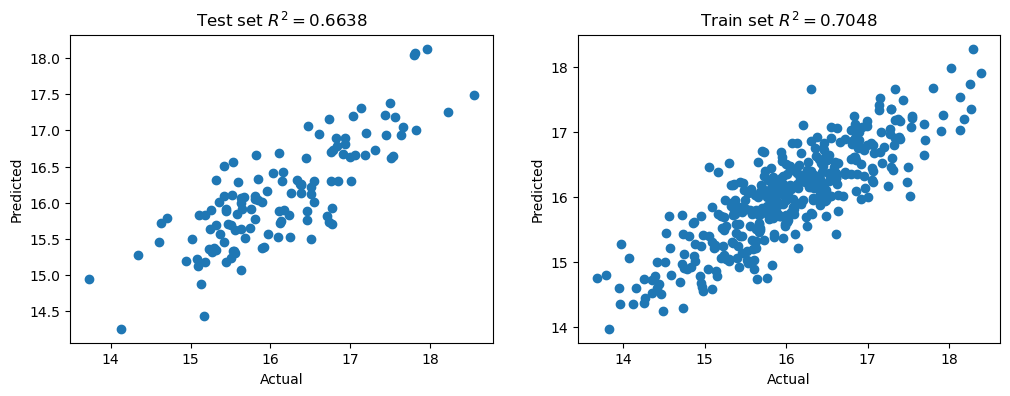

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].plot(
    y_test,
    pls.predict(X_test),
    'o'
)
_ = axes[0].set_title(f"Test set $R^2 = {'%.4f'%pls.score(X_test, y_test)}$")

axes[1].plot(
    y_train,
    pls.predict(X_train),
    'o'
)
_ = axes[1].set_title(f"Train set $R^2 = {'%.4f'%pls.score(X_train, y_train)}$")

for ax in axes:
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

Text(0, 0.5, 'Feature 2')

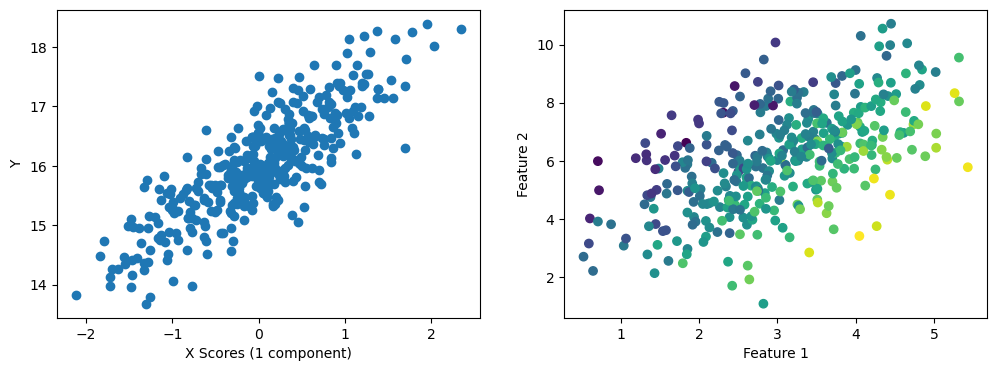

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].plot(pls.transform(X_train), y_train, 'o')
axes[0].set_xlabel('X Scores (1 component)')
axes[0].set_ylabel('Y')

axes[1].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='viridis')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')